<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.3.ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1.2. ARIMAX Estimation

### ARIMA 오차 회귀 모델을 통한 분기별 미국 소비 변화 추정

#### 1) 모듈과 데이터 불러오기

In [11]:
#모듈 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [4]:
#데이터 불러오기
us_change = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.4/us_change.csv")
us_change = us_change[["Consumption","Income", "Production", "Savings", "Unemployment"]]
us_change.index = pd.date_range(start='1970/01/01', periods=198, freq='3MS')

us_change

,Consumption,Income,Production,Savings,Unemployment
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...
2018-04-01,0.983112,0.661825,1.117424,-2.723974,0.0
2018-07-01,0.853181,0.806271,1.256722,-0.085686,-0.3
2018-10-01,0.356512,0.695142,0.948148,5.031337,0.2
2019-01-01,0.282885,1.100753,-0.488206,9.760287,-0.1


#### 2) 전력 소비량과 외부 변수 시각화

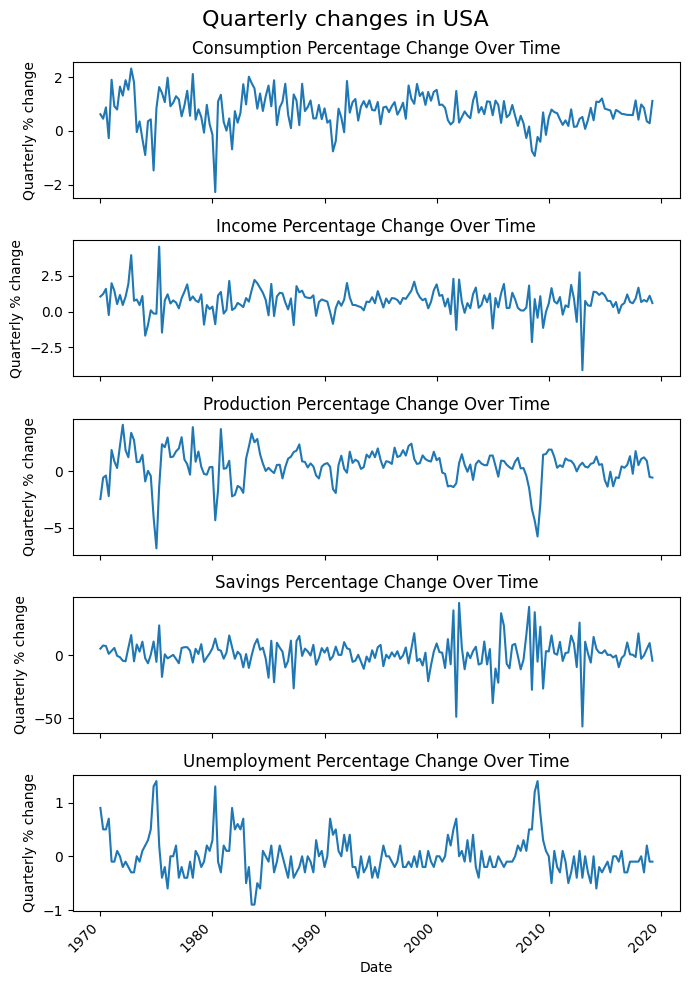

In [10]:
#데이터 시각화
fig, axes = plt.subplots(us_change.shape[1], 1, figsize=(7, 10), sharex=True)

for i, var in enumerate(us_change.columns):
    axes[i].plot(us_change[var], label=var)
    axes[i].set_ylabel("Quarterly % change")
    axes[i].set_title(f'{var} Percentage Change Over Time')

axes[-1].set_xlabel('Date')
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle("Quarterly changes in USA", fontsize=16)
plt.tight_layout()
plt.show()

#### 3) 정상성 확인

In [12]:
#Adfuller test
print(adfuller(us_change["Consumption"])[1])

0.0001237324092713116


#### 4) 최적의 SARIMA(p, d, q), (P, D, Q, S) 모델 선택

In [13]:
#ARIMA 파라미터 최적화 함수
def ARIMAX_optimizer(y, X):
    result= []
    for p in range(4):
        for q in range(4):
            try:
                model = SARIMAX(y, X, order=(p, 0, q), simple_differencing=False).fit(dips=False)
            except:
                continue

            aic = model.aic
            result.append([p, q, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['p', 'q', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
#오차 차수 최적화하기
result = ARIMAX_optimizer(us_change["Consumption"], us_change[ ["Income", "Production", "Savings", "Unemployment"] ])
result

,p,q,AIC
0,2,2,112.974286
1,2,3,114.762318
2,2,1,115.101881
3,3,2,117.538394
4,3,1,118.221254
5,3,3,120.239590
6,3,0,144.953644
7,2,0,146.860193
8,0,2,148.947838
9,1,1,149.570145


#### 5) 모델 적합 결과

In [15]:
#실제 모델 적합
model = SARIMAX(us_change["Consumption"], us_change[ ["Income", "Production", "Savings", "Unemployment"] ], order=(2, 0, 2), simple_differencing=False)
fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -47.487
Date:                Tue, 31 Dec 2024   AIC                            112.974
Time:                        16:22:05   BIC                            142.569
Sample:                    01-01-1970   HQIC                           124.953
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.7275      0.029     24.742      0.000       0.670       0.785
Production       0.0454      0.028      1.621      0.105      -0.009       0.100
Savings         -0.0521      0.002    -26.246      0.000      -0.056      -0.048
Unemployment    -0.1938      0.139     -1.390      0.165      -0.467       0.080
ar.L1            0.0093      0.018      0.515      0.607      -0.026       0.045
ar.L2            0.9900      0.018     54.927      0.000       0.955       1.025
ma.L1           -0.0086      0.044     -0.196      0.845      -0.095       0.078
ma.L2           -0.9458      0.045    -21.125      0.000      -1.034      -0.858
sigma2           0.0935      0.008     11.550      0.000       0.078       0.109
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):                25.21
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6) 모델 적합성 검증

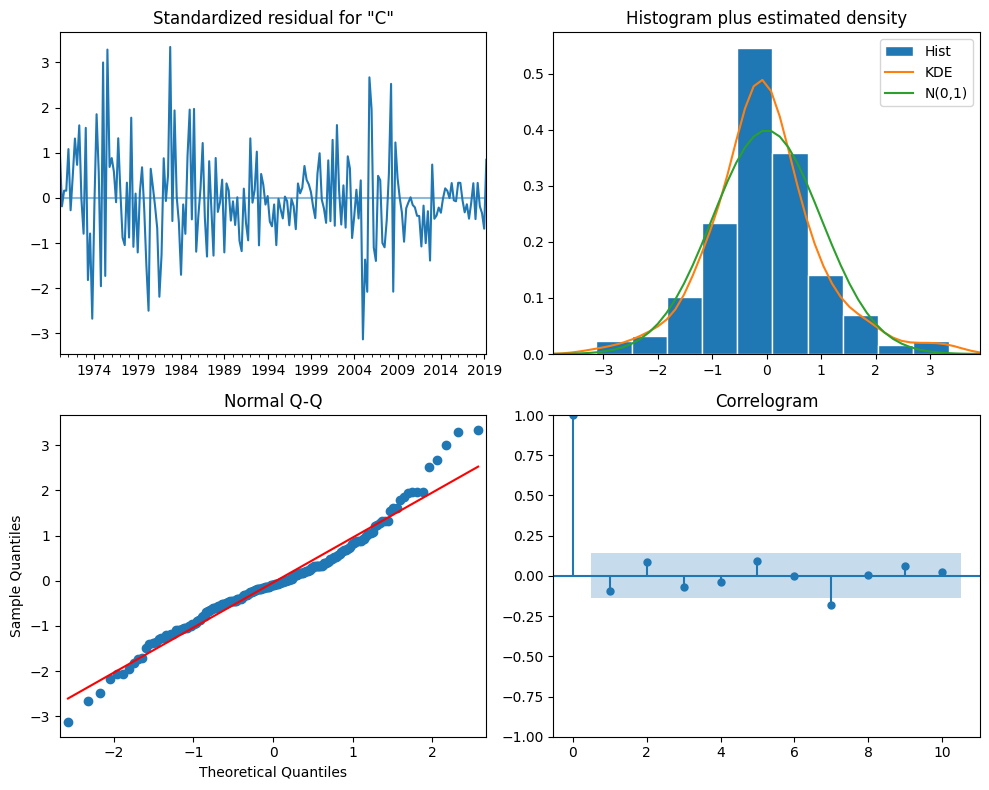

In [16]:
#잔차 확인
fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

# 4.1.3. ARIMAX Forecasting

### ARIMA 오차 회귀 모델을 통한 분기별 미국 소비 변화 예측

#### 1) 정상성 확인

In [17]:
#Adfuller test
print(adfuller(us_change["Consumption"][:193])[1])

0.00016836297275978242


#### 2) 최적의 ARIMA(p, d, q) 모델 선택

In [18]:
#오차 차수 최적화하기
result = ARIMAX_optimizer(us_change["Consumption"][:193], us_change[ ["Income", "Production", "Savings", "Unemployment"] ][:193])
result

,p,q,AIC
0,2,3,114.373086
1,3,2,115.388935
2,3,3,122.280935
3,2,1,133.476591
4,3,1,144.519662
5,3,0,144.711342
6,2,0,146.763177
7,0,2,149.045441
8,1,1,150.019959
9,1,2,150.599096


#### 3) 모델 적합

In [19]:
#실제 모델 적합
model = SARIMAX(us_change["Consumption"][:193], us_change[ ["Income", "Production", "Savings", "Unemployment"] ][:193], order=(2, 0, 3), simple_differencing=False)
fit = model.fit(disp=False)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  193
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 -47.187
Date:                Tue, 31 Dec 2024   AIC                            114.373
Time:                        16:35:41   BIC                            147.000
Sample:                    01-01-1970   HQIC                           127.586
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Income           0.7504      0.030     25.042      0.000       0.692       0.809
Production       0.0423      0.028      1.486      0.137      -0.013       0.098
Savings         -0.0532      0.002    -27.074      0.000      -0.057      -0.049
Unemployment    -0.1860      0.141     -1.322      0.186      -0.462       0.090
ar.L1            0.0250      0.054      0.461      0.645      -0.081       0.131
ar.L2            0.9741      0.054     18.026      0.000       0.868       1.080
ma.L1           -0.1111      0.080     -1.396      0.163      -0.267       0.045
ma.L2           -0.9272      0.081    -11.461      0.000      -1.086      -0.769
ma.L3            0.0848      0.071      1.195      0.232      -0.054       0.224
sigma2           0.0941      0.008     11.105      0.000       0.077       0.111
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                22.84
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 4) 모델을 이용한 예측

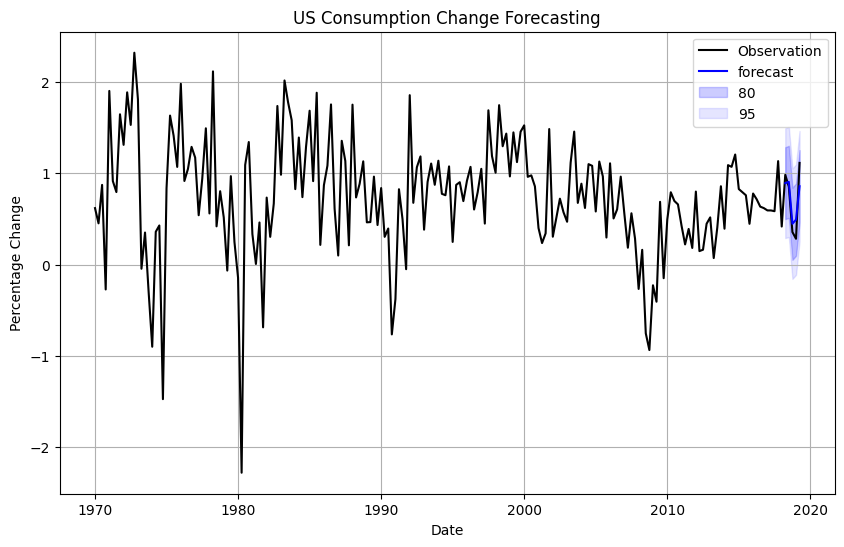

In [20]:
#ARIMAX 예측값 구하기기
forecast_result = fit.get_forecast(5, exog=us_change[ ["Income", "Production", "Savings", "Unemployment"] ].iloc[193:])
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:,1]

#예측 시각화
plt.figure(figsize=(10, 6))
plt.plot(us_change["Consumption"], label='Observation', color='black')
plt.plot(forecast_mean, label='forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.title("US Consumption Change Forecasting")
plt.grid(True)
plt.legend()
plt.show()